# Birefringence and phase reconstruction with multi-threading + GPU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import glob
from PIL import Image
import os
from skimage import io
from scipy.ndimage import uniform_filter
from joblib import Parallel, delayed


import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
n_media       = 1                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 10                  # magnification of the microscope                      
NA_obj        = 0.3                # detection NA of the objective
NA_illu       = 0.28                 # illumination NA of the condenser
N_defocus     = 5                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 6               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-2)*z_step
chi           = 0.1*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/Spinningdisk/RawData/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/SMS_062019_1250_1/'        # data path
bg_path       = '/gpfs/CompMicro/Spinningdisk/RawData/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/BG_2019_0620_1246_1/Pos0/'           # background data path
output_path   = '/gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/'      # output image path
use_gpu       = True
gpu_id        = 2

In [3]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    reg_u = 1e-4      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-4      # phase regularizer
    lambda_u = 1e-5   # absorption regularizer
    lambda_p = 1e-5   # phase regularizer
    rho = 1           # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 50          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [4]:
# Plot setting

max_phase = 1.5                   # maximum phase value to display
min_phase = -1.5                     # minimum phase value to display

max_ret   = 15e-3/lambda_illu*2*np.pi # maximum retardance value
z_layer   = 2                        # focal layer to plot if only plot single layer

In [5]:
# metadata file loading

import json

f = open(data_path+'3-Pos_001_000/metadata.txt')
data = json.load(f)
N_pos = len(data['Summary']['InitialPositionList'])
filedir = []
for i in range(N_pos):
    filedir.append(data_path+data['Summary']['InitialPositionList'][i]['Label']+'/')

f.close()

In [6]:
files = []
for i in range(len(filedir)):
    files.append(sorted(glob.glob(filedir[i]+'*PolState*.tif'), key=wo.numericalSort))
    
filedir_bg = bg_path + '*State*.tif'
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

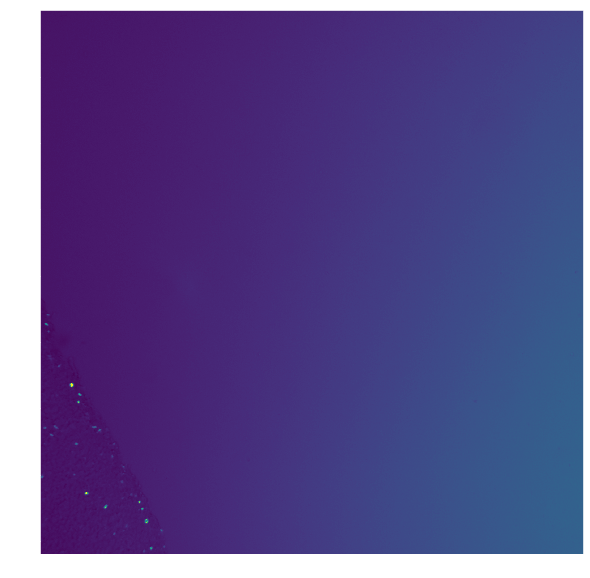

In [7]:
# select a FOV for processing


Ns = 2048
Ms = 2048
n_start = [0, 0] 


plt.figure(figsize=(10,10))
plt.imshow(plt.imread(files[45][15]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms])


In [8]:

setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option, use_gpu=use_gpu, gpu_id=gpu_id)


Finished constructing basic parameters, elapsed time 0.37


In [9]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'phase_u16')
os.system('mkdir '+output_path+'birefringence')
os.system('mkdir '+output_path+'birefringence2')


Nimg = N_defocus*N_channel
N_time = len(files[0])//Nimg
N_pos = len(files)


# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

t0 = time.time()

for p in range(N_pos):
    
    for m in range(N_time):

        # Load Polscope images
        I_meas_pre =[]

        for i in range(0, Nimg):
            Itemp = io.imread(files[p][m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
            I_meas_pre.append(Itemp)
        I_meas_pre = np.array(I_meas_pre)
        I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

        # intensity mapping to match the theory
        I_meas = np.zeros_like(I_meas_pre)
        for i in range(N_defocus):
            I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])


        # Stokes vector recon with bg correction
        S_image_recon = setup.Stokes_recon(I_meas)
        S_bg_recon = setup.Stokes_recon(I_bg)
        S_image_tm = setup.Stokes_transform(S_image_recon)
        S_bg_tm = setup.Stokes_transform(S_bg_recon)
        S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)  
        Recon_para = setup.Polarization_recon(S_image_tm)



        # Take out S0 for phase reconstruction
        S0_stack = S_image_tm[0].copy()


        # Phase reconstruction

        if deconv == 'Tikhonov':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p)

        elif deconv == 'TV':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', reg_u = reg_u, reg_p = reg_p, lambda_u = lambda_u, lambda_p = lambda_p, \
                                                      itr = itr, rho=rho, verbose = verbose)


        # figure plotting as tiff files
        
        file_name_phase = output_path+'phase/img_phase'+'_t'+str(m).zfill(3)+'_p'+str(p).zfill(3)+'_z'+str(2).zfill(3)+'.tif'
        plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)
        
        
        phi_sample_u16 = phi_sample-np.min(phi_sample)
        phi_sample_u16 = np.uint16(phi_sample_u16/np.max(phi_sample_u16)*(2**16-1))
        
        
        
        file_name_phase_u16 = output_path+'phase_u16/img_phase'+'_t'+str(m).zfill(3)+'_p'+str(p).zfill(3)+'_z'+str(2).zfill(3)+'.tif'
        io.imsave(file_name_phase_u16, phi_sample_u16)
        
        
        bi_hsv_1 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                               np.ones((Ns,Ms)), \
                                               np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
        
        bi_rgb_temp = hsv_to_rgb(bi_hsv_1.copy())
        bi_rgb_1 = bi_rgb_temp.copy()

        norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
        norm_phase /= np.max(norm_phase)
        bi_hsv_2 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                           np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                           norm_phase]), (1,2,0))
        
        bi_rgb_temp = hsv_to_rgb(bi_hsv_2.copy())
        bi_rgb_2 = bi_rgb_temp.copy()


        file_name_bire = output_path+'birefringence/img_Retardance+Orientation'+'_t'+str(m).zfill(3)+'_p'+str(p).zfill(3)+'_z'+str(z_layer).zfill(3)+'.tif'
        plt.imsave(file_name_bire, bi_rgb_1, format="tiff")

        file_name_bire = output_path+'birefringence2/img_Retardance+Orientation+Phase'+'_t'+str(m).zfill(3)+'_p'+str(p).zfill(3)+'_z'+str(z_layer).zfill(3)+'.tif'
        plt.imsave(file_name_bire, bi_rgb_2, format="tiff")


    print('Processed at time frame (%d / %d), position (%d / %d), elapsed time: %.2f'%(m+1,N_time,p+1,N_pos, time.time()-t0))



/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p000_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (1 / 240), elapsed time: 9.81


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p001_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (2 / 240), elapsed time: 18.85
Processed at time frame (1 / 1), position (3 / 240), elapsed time: 27.85
Processed at time frame (1 / 1), position (4 / 240), elapsed time: 36.76
Processed at time frame (1 / 1), position (5 / 240), elapsed time: 45.78
Processed at time frame (1 / 1), position (6 / 240), elapsed time: 54.47
Processed at time frame (1 / 1), position (7 / 240), elapsed time: 63.12
Processed at time frame (1 / 1), position (8 / 240), elapsed time: 71.82
Processed at time frame (1 / 1), position (9 / 240), elapsed time: 80.53
Processed at time frame (1 / 1), position (10 / 240), elapsed time: 89.29
Processed at time frame (1 / 1), position (11 / 240), elapsed time: 98.12


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p011_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (12 / 240), elapsed time: 106.91


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p012_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (13 / 240), elapsed time: 115.65
Processed at time frame (1 / 1), position (14 / 240), elapsed time: 124.36


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p014_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (15 / 240), elapsed time: 133.10
Processed at time frame (1 / 1), position (16 / 240), elapsed time: 141.83


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p016_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (17 / 240), elapsed time: 150.60
Processed at time frame (1 / 1), position (18 / 240), elapsed time: 159.56
Processed at time frame (1 / 1), position (19 / 240), elapsed time: 168.26
Processed at time frame (1 / 1), position (20 / 240), elapsed time: 177.03
Processed at time frame (1 / 1), position (21 / 240), elapsed time: 185.79
Processed at time frame (1 / 1), position (22 / 240), elapsed time: 194.47
Processed at time frame (1 / 1), position (23 / 240), elapsed time: 203.14
Processed at time frame (1 / 1), position (24 / 240), elapsed time: 211.71
Processed at time frame (1 / 1), position (25 / 240), elapsed time: 220.27
Processed at time frame (1 / 1), position (26 / 240), elapsed time: 228.90
Processed at time frame (1 / 1), position (27 / 240), elapsed time: 237.58
Processed at time frame (1 / 1), position (28 / 240), elapsed time: 246.27
Processed at time frame (1 / 1), position (29 / 240), elapsed time: 255.20
Processed at time frame (

/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p030_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (31 / 240), elapsed time: 272.53
Processed at time frame (1 / 1), position (32 / 240), elapsed time: 281.34
Processed at time frame (1 / 1), position (33 / 240), elapsed time: 290.00
Processed at time frame (1 / 1), position (34 / 240), elapsed time: 298.76
Processed at time frame (1 / 1), position (35 / 240), elapsed time: 307.42
Processed at time frame (1 / 1), position (36 / 240), elapsed time: 316.03
Processed at time frame (1 / 1), position (37 / 240), elapsed time: 324.62
Processed at time frame (1 / 1), position (38 / 240), elapsed time: 333.15
Processed at time frame (1 / 1), position (39 / 240), elapsed time: 341.76
Processed at time frame (1 / 1), position (40 / 240), elapsed time: 350.34
Processed at time frame (1 / 1), position (41 / 240), elapsed time: 359.14
Processed at time frame (1 / 1), position (42 / 240), elapsed time: 367.86
Processed at time frame (1 / 1), position (43 / 240), elapsed time: 376.49
Processed at time frame (

/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p149_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (150 / 240), elapsed time: 1301.90
Processed at time frame (1 / 1), position (151 / 240), elapsed time: 1310.62
Processed at time frame (1 / 1), position (152 / 240), elapsed time: 1319.55
Processed at time frame (1 / 1), position (153 / 240), elapsed time: 1328.16
Processed at time frame (1 / 1), position (154 / 240), elapsed time: 1336.89
Processed at time frame (1 / 1), position (155 / 240), elapsed time: 1345.99
Processed at time frame (1 / 1), position (156 / 240), elapsed time: 1354.61
Processed at time frame (1 / 1), position (157 / 240), elapsed time: 1363.15
Processed at time frame (1 / 1), position (158 / 240), elapsed time: 1371.70
Processed at time frame (1 / 1), position (159 / 240), elapsed time: 1380.32
Processed at time frame (1 / 1), position (160 / 240), elapsed time: 1388.81
Processed at time frame (1 / 1), position (161 / 240), elapsed time: 1397.45
Processed at time frame (1 / 1), position (162 / 240), elapsed time: 1406.46

/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p190_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (191 / 240), elapsed time: 1671.10
Processed at time frame (1 / 1), position (192 / 240), elapsed time: 1680.06
Processed at time frame (1 / 1), position (193 / 240), elapsed time: 1688.99
Processed at time frame (1 / 1), position (194 / 240), elapsed time: 1697.84


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p194_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (195 / 240), elapsed time: 1706.76
Processed at time frame (1 / 1), position (196 / 240), elapsed time: 1715.70


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p196_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (197 / 240), elapsed time: 1724.40
Processed at time frame (1 / 1), position (198 / 240), elapsed time: 1733.31


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p198_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (199 / 240), elapsed time: 1742.23
Processed at time frame (1 / 1), position (200 / 240), elapsed time: 1751.67
Processed at time frame (1 / 1), position (201 / 240), elapsed time: 1760.46
Processed at time frame (1 / 1), position (202 / 240), elapsed time: 1769.25
Processed at time frame (1 / 1), position (203 / 240), elapsed time: 1777.91
Processed at time frame (1 / 1), position (204 / 240), elapsed time: 1786.70
Processed at time frame (1 / 1), position (205 / 240), elapsed time: 1795.66


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p205_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (206 / 240), elapsed time: 1804.80
Processed at time frame (1 / 1), position (207 / 240), elapsed time: 1813.63
Processed at time frame (1 / 1), position (208 / 240), elapsed time: 1822.29
Processed at time frame (1 / 1), position (209 / 240), elapsed time: 1830.88
Processed at time frame (1 / 1), position (210 / 240), elapsed time: 1839.68
Processed at time frame (1 / 1), position (211 / 240), elapsed time: 1848.70
Processed at time frame (1 / 1), position (212 / 240), elapsed time: 1857.77
Processed at time frame (1 / 1), position (213 / 240), elapsed time: 1866.45
Processed at time frame (1 / 1), position (214 / 240), elapsed time: 1875.56
Processed at time frame (1 / 1), position (215 / 240), elapsed time: 1884.51


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p215_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (216 / 240), elapsed time: 1893.38
Processed at time frame (1 / 1), position (217 / 240), elapsed time: 1902.12
Processed at time frame (1 / 1), position (218 / 240), elapsed time: 1911.29
Processed at time frame (1 / 1), position (219 / 240), elapsed time: 1920.22
Processed at time frame (1 / 1), position (220 / 240), elapsed time: 1930.29


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p220_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (221 / 240), elapsed time: 1941.22


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p221_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (222 / 240), elapsed time: 1952.27
Processed at time frame (1 / 1), position (223 / 240), elapsed time: 1961.24
Processed at time frame (1 / 1), position (224 / 240), elapsed time: 1969.83


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p224_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (225 / 240), elapsed time: 1978.59
Processed at time frame (1 / 1), position (226 / 240), elapsed time: 1987.25


/data_sm/home/lihao/anaconda3/envs/waveorder/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /gpfs/CompMicro/Projects/brainarchitecture/2019_06_20_GW24_reimaging_594Fluoromyelin_10X_test/LiHao_processing/phase_u16/img_phase_t000_p226_z002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Processed at time frame (1 / 1), position (227 / 240), elapsed time: 1995.87
Processed at time frame (1 / 1), position (228 / 240), elapsed time: 2004.49
Processed at time frame (1 / 1), position (229 / 240), elapsed time: 2013.17
Processed at time frame (1 / 1), position (230 / 240), elapsed time: 2021.83
Processed at time frame (1 / 1), position (231 / 240), elapsed time: 2030.39
Processed at time frame (1 / 1), position (232 / 240), elapsed time: 2039.05
Processed at time frame (1 / 1), position (233 / 240), elapsed time: 2047.84
Processed at time frame (1 / 1), position (234 / 240), elapsed time: 2056.53
Processed at time frame (1 / 1), position (235 / 240), elapsed time: 2065.18
Processed at time frame (1 / 1), position (236 / 240), elapsed time: 2074.00
Processed at time frame (1 / 1), position (237 / 240), elapsed time: 2082.52
Processed at time frame (1 / 1), position (238 / 240), elapsed time: 2091.11
Processed at time frame (1 / 1), position (239 / 240), elapsed time: 2099.73

In [10]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()